In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import numpy as np 
import math

In [3]:
dfdata = pd.read_csv('/content/drive/MyDrive/TH1391_NLMH/Week9_Thuchanh3/credit.csv')
# dfdata.head(5)
dfdata

,ID,AGE,JOB_STATUS,OWNS_HOUSE,CREDIT_RATING,CLASS
0,1,Young,False,False,Fair,No
1,2,Young,False,False,Good,No
2,3,Young,True,False,Good,Yes
3,4,Young,True,True,Fair,Yes
4,5,Young,False,False,Fair,No
5,6,Middle,False,False,Fair,No
6,7,Middle,False,False,Good,No
7,8,Middle,True,True,Good,Yes
8,9,Middle,False,True,Excellent,Yes
9,10,Middle,False,True,Excellent,Yes


In [4]:
data_train=dfdata.iloc[:,1:]
data_train.head(5)

,AGE,JOB_STATUS,OWNS_HOUSE,CREDIT_RATING,CLASS
0,Young,False,False,Fair,No
1,Young,False,False,Good,No
2,Young,True,False,Good,Yes
3,Young,True,True,Fair,Yes
4,Young,False,False,Fair,No


In [5]:
attrs = dfdata.columns[1:]
attrs

Index(['AGE', 'JOB_STATUS', 'OWNS_HOUSE', 'CREDIT_RATING', 'CLASS'], dtype='object')

In [6]:
class Tree:
  def __init__(self,observationIDs,features,currLvl=0,subTree={},bestFeature=None,majorityLabel=None,parentMajorityLabel=None):
    self.observationIDs = observationIDs
    self.features = features
    self.currLvl = currLvl
    self.subTree = subTree
    self.bestFeature = bestFeature
    self.majorityLabel = majorityLabel
    self.parentMajorityLabel = parentMajorityLabel
    self.setBestFeatureID(bestFeature)
    
  def setBestFeatureID(self, feature):
    if feature == 'AGE':
      idx = 0
    elif feature == 'JOB_STATUS':
      idx = 1
    elif feature == 'OWNS_HOUSE':
      idx = 2
    elif feature == 'CREDIT_RATING':
      idx = 3
    else:
      idx = None  # Tạo điều kiện cho các trường hợp khác
    self.bestFeatureID = idx

In [7]:
def predict(tree, obs):
	if tree.bestFeature == None:
		return tree.majorityLabel
	featVal = obs[tree.bestFeatureID]
	if not featVal in tree.subTree: # val with no subtree
		return tree.majorityLabel
	else: # recurse on subtree
		return predict(tree.subTree[featVal],obs)

In [8]:
def displayDecisionTree(tree):
	print('\t'*tree.currLvl + '(lvl {}) {}'.format(tree.currLvl,tree.majorityLabel))
	if tree.bestFeature == None:
		return

	print('\t'*tree.currLvl + '{}'.format(tree.bestFeature) + ': ')
	for [val,subTree] in sorted(tree.subTree.items()):
		print('\t'*(tree.currLvl+1) + 'choice: {}'.format(val))
		displayDecisionTree(subTree)

In [9]:
def Entropy(ns):
	entropy = 0.0
	total = sum(ns)
	for x in ns:
		entropy += -1.0*x/total*math.log(1.0*x/total,2)
	return entropy

In [10]:
def IG(observationIDs, feature, dfdata):
	# get smaller dataframe
	df = dfdata.loc[list(observationIDs)]
	# populate counts for Wins/Losses for each category of the feature
	labelCountDict = {}
	valueLabelCountDict = {}
	for index, row in df.iterrows():
		label = row['CLASS']
		if not label in labelCountDict:
			labelCountDict[label] = 0 # this specific label was not found so insert 0 count
		labelCountDict[label] += 1
		featureValue = row[feature]
		if not featureValue in valueLabelCountDict:
			valueLabelCountDict[featureValue] = {} # this specific feature value not found so insert empty dict
		if not label in valueLabelCountDict[featureValue]:
			valueLabelCountDict[featureValue][label] = 0 # this specific label was not found for this feature value so insert 0 count
		valueLabelCountDict[featureValue][label] += 1

	ns = []
	for [label,count] in labelCountDict.items():
		ns.append(count)

	H_Y = Entropy(ns)

	H_Y_X = 0.0
	for [featureValue, labelCountDict] in valueLabelCountDict.items():
		nsHYX = []
		for [label,count] in labelCountDict.items():
			nsHYX.append(count)
		H_Y_X += 1.0*sum(nsHYX)/len(df)*Entropy(nsHYX)
	return H_Y - H_Y_X

In [11]:
def GR(observationIDs, feature,dfdata):
	ig = IG(observationIDs,feature)
	if ig == 0:
		return 0
	df = dfdata.loc[list(observationIDs)]
	valueLabelDict = {}
	for index, row in df.iterrows():
		label = row['CLASS']
		featureValue = row[feature]
		if featureValue not in valueLabelDict:
			valueLabelDict[featureValue] = 0
		valueLabelDict[featureValue] += 1
	ns = []
	for [val,count] in valueLabelDict.items():
		ns.append(count)
	ent = Entropy(ns)
	return float(ig)/ent

In [12]:
def fillDecisionTree(tree,decisionTreeAlgo,dfdata):
  # find the majorityLabel
  df = dfdata.loc[list(tree.observationIDs)] # smaller df
  counts = df['CLASS'].value_counts()
  majorityLabel = df['CLASS'].value_counts().idxmax()
  if len(counts) > 1:
    if counts['Yes'] == counts['No']:
      majorityLabel = tree.parentMajorityLabel
  tree.majorityLabel = majorityLabel

  # exit if only one label
  if len(counts) == 1:
    return
  # exit if no features left
  if len(tree.features) == 0: 
    return

  # find best feature
  featureValueDict = {}
  for feature in tree.features: 
    if decisionTreeAlgo == 'ID3':
      metricScore = IG(tree.observationIDs,feature,dfdata)
    if decisionTreeAlgo == 'C45':
      metricScore = GR(tree.observationIDs,feature,dfdata)
    featureValueDict[feature] = metricScore
  bestFeature, bestFeatureValue = sorted(featureValueDict.items(),reverse=True)[0]
  # exit if IG or GR is 0
  if bestFeatureValue == 0.0:
    return
  tree.bestFeature = bestFeature

  # find subset of features
  subFeatures = set()
  for feature in tree.features:
    if feature == bestFeature: # skip the current best feature
      continue
    subFeatures.add(feature)
  
  # find best feature id
  bestFeatureIdx = 0
  if bestFeature == 'AGE':
    bestFeatureIdx = 0
  elif bestFeature == 'JOB_STATUS':
    bestFeatureIdx = 1
  elif bestFeature == 'OWNS_HOUSE':
    bestFeatureIdx = 2
  else:
    bestFeatureIdx = 3
  
  
  # find subset of observations
  subObservationsDict = {}
  for obs in tree.observationIDs:
    val = dfdata.values[obs][bestFeatureIdx]
    if not val in subObservationsDict:
      subObservationsDict[val] = set()
    subObservationsDict[val].add(obs)

  for [val,obs] in subObservationsDict.items():

    tree.subTree[val] = Tree(obs, subFeatures, tree.currLvl + 1,{},None,None,majorityLabel)
    
    fillDecisionTree(tree.subTree[val],decisionTreeAlgo,dfdata)

In [13]:
initialObservationIDs = set(range(len(data_train)))
initialFeatures = set(attrs)

In [14]:
initialObservationIDs

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [15]:
initialFeatures

{'AGE', 'CLASS', 'CREDIT_RATING', 'JOB_STATUS', 'OWNS_HOUSE'}

In [16]:
algoChoice = 'ID3'
print("choice: {}".format(algoChoice))

choice: ID3


In [17]:
MyTree = Tree(initialObservationIDs, initialFeatures)
fillDecisionTree(MyTree, algoChoice, dfdata.iloc[:,1:])

print('My Decision Tree:')
displayDecisionTree(MyTree)

My Decision Tree:
(lvl 0) Yes
OWNS_HOUSE: 
	choice: False
	(lvl 1) No
	JOB_STATUS: 
		choice: False
		(lvl 2) No
		choice: True
		(lvl 2) Yes
	choice: True
	(lvl 1) Yes


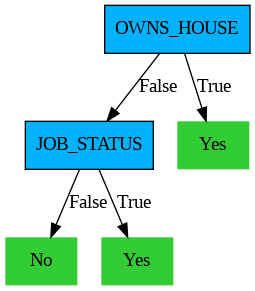

In [18]:
# Vẽ hình
from IPython.display import Image
import pydotplus
import graphviz

def visualize_tree(tree, feature_names=dfdata.columns[1:], class_names=data_train[data_train.columns[-1]].unique(), label='root'):
    if tree.bestFeature is None:
        node_attr = {'shape': 'plaintext', 'style': 'filled', 'fillcolor': 'limegreen'}
        graph = graphviz.Digraph(node_attr=node_attr, format='png')
        graph.attr(bgcolor='transparent')
        graph.node(label, f"{tree.majorityLabel}")
        return graph

    dot = graphviz.Digraph(node_attr={'shape': 'box', 'style': 'filled', 'fillcolor': '#00B2FC'}, format='png')
    dot.attr(bgcolor='transparent')
    dot.node(label, tree.bestFeature)

    for val, sub_tree in tree.subTree.items():
        sub_label = f"{label}-{val}"
        dot.subgraph(visualize_tree(sub_tree, feature_names, class_names, sub_label))
        dot.edge(label, sub_label, label=f"{val}", color='black')

    return dot

dot = visualize_tree(MyTree)
graph = pydotplus.graph_from_dot_data(dot.source)
Image(graph.create_png())

In [19]:
data_test = dfdata.iloc[:, 1:-1]
data_test

,AGE,JOB_STATUS,OWNS_HOUSE,CREDIT_RATING
0,Young,False,False,Fair
1,Young,False,False,Good
2,Young,True,False,Good
3,Young,True,True,Fair
4,Young,False,False,Fair
5,Middle,False,False,Fair
6,Middle,False,False,Good
7,Middle,True,True,Good
8,Middle,False,True,Excellent
9,Middle,False,True,Excellent


In [20]:
# Use the ID3 decision tree to predict labels for test data
for index, row in data_test.iterrows():
    obs_row = [row[0], row[1], row[2], row[3]]
    pred = predict(MyTree, obs_row)
    print(f'Prediction for {obs_row}: {pred}')

TypeError: ignored